<h1 style="color: #1E90FF;">Minimum Cut in Flow Graph Using Dijkstra's Algorithm</h1>


This Jupyter notebook presents a method for representing random quantum circuits using graphs, and then finding the minimum cut of the graph that separates two specific qubits. The process begins by extracting information from the flow of the graph, which refers to the movement within the graph via cuts. To achieve this, minimal cycles of the graph are identified, which serve as the basis for the representation. These cycles are then treated as nodes in a new graph, with edges connecting them. The weight of each edge corresponds to the cost of transitioning between cycles, or in other words, cutting from one cycle to another by passing through the shared edge.

In this newly created graph, the shortest path is determined using Dijkstra's algorithm, starting from the cycle corresponding to the two qubits that were initially intended to be partitioned (which are now represented as a node), and ending at a cycle that is added to the graph, which represents the equivalent of exiting the bottom of the circuit (denoted by the node "s" in the new graph). The cost of traversing this path is precisely the value of the minimum cut that was sought. This method provides a way to efficiently model and compute the minimum cut in a quantum circuit structure using graph theory and optimization techniques.

<h2 style="color: #FF6347;">The following are functions to create and draw a graph and a circuit of a random quantum circuit.</h2>


In [17]:
from qiskit import QuantumCircuit
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.patches import Polygon

# Function to plot the circuit graph
def draw_circuit_graph(G, pos):
    """
    This function plots the graph representing the quantum circuit. 
    Nodes are colored based on whether they represent qubits or gates.
    """
    plt.figure(figsize=(7, 7))

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    nx.draw(G, pos, with_labels=True,
            labels=nx.get_node_attributes(G, 'label'), 
            node_color=list(nx.get_node_attributes(G, 'node_color').values()),
            edge_color="black",
            node_size=800, font_size=9, font_weight="bold")
    
    plt.title("Graph Representing the Circuit ")
    plt.show()

# Function to convert a random circuit to a graph
def random_circuit_to_graph(n_qubits, depth, doped=0):
    """
    This function generates a random quantum circuit and converts it to a graph. 
    Each qubit is represented as a node, and gates are added as nodes with edges 
    connecting them to the relevant qubits.
    """
    G = nx.Graph()
    pos = {}

    # Add nodes for each qubit and their labels
    qubit_top_nodes = []
    for qubit in range(n_qubits):
        qubit_top_node = f'q_top_{qubit}'
        qubit_bottom_node = f'q_bottom_{qubit}'
        G.add_node(qubit_bottom_node, label=f'q_{qubit}', node_color='lightgreen')
        G.add_node(qubit_top_node, label=f'q_{qubit}', node_color='lightgreen')
        qubit_top_nodes.append(qubit_top_node)
        pos[f'q_bottom_{qubit}'] = (qubit, 0)  
        pos[f'q_top_{qubit}'] = (qubit, depth + 2)  

    gate_counter = 0
    previous_gate_nodes = {}
    gates = []
    gates_doped = random.sample(range(depth), min(int(doped * depth), depth))
    
    for _ in range(depth):  # Generate random gates based on the 'depth'
        # Randomly choose two or three consecutive qubits

        gate_id = f'gate_{gate_counter}'
        
        if gate_counter in gates_doped:
            qubit1 = random.randint(0, n_qubits - 3)  
            qubit2 = qubit1 + 1  
            qubit3 = qubit1 + 2
            gate = [qubit1, qubit2, qubit3]
            G.add_node(gate_id, label=gate_id, node_color='red')
            pos_gate = (qubit2, gate_counter + 1)
            
        else:
            qubit1 = random.randint(0, n_qubits - 2)  
            qubit2 = qubit1 + 1 
            gate = [qubit1, qubit2]
            G.add_node(gate_id, label=gate_id, node_color='skyblue')
            pos_gate = ((qubit1 + qubit2) / 2, gate_counter + 1)

        gates.append(gate + [gate_counter])
        pos[gate_id] = pos_gate 

        # Create connections with the qubits
        gate_weight = 2
        for qubit_index in gate:
            if qubit_index in previous_gate_nodes:
                # If there is a previous gate on the same qubit, connect with weight 2
                if G.has_edge(gate_id, previous_gate_nodes[qubit_index]):
                    G[gate_id][previous_gate_nodes[qubit_index]]['weight'] = gate_weight
                    gate_weight += 1
                else:
                    G.add_edge(gate_id, previous_gate_nodes[qubit_index], weight=1)
            else:
                # Connect the gate with the initial qubit with weight 1
                G.add_edge(gate_id, f'q_bottom_{qubit_index}', weight=1)
            
            previous_gate_nodes[qubit_index] = gate_id

        gate_counter += 1

    # Connect the final gate nodes with the top qubits
    for qubit_index in range(n_qubits):
        if qubit_index in previous_gate_nodes:
            G.add_edge(previous_gate_nodes[qubit_index], f'q_top_{qubit_index}', weight=1)
        else:
            G.add_edge(f'q_bottom_{qubit_index}', f'q_top_{qubit_index}', weight=1)

    return G, pos, gates

# Create a quantum circuit given the gates
def gates_to_circuit(n_qubits, gates):
    """
    This function generates a quantum circuit based on a list of gates. 
    Each pair of qubits in the gates list is connected by a CNOT gate.
    """
    qc = QuantumCircuit(n_qubits)
    for gate in gates:
        if len(gate) == 3:
            qubit1, qubit2, _ = gate
            qc.cx(qubit1, qubit2)
        elif len(gate) == 4:
            qubit1, qubit2, qubit3, _ = gate
            qc.ccx(qubit1, qubit2, qubit3)
    return qc


<h2 style="color: #FF6347;"> Cycles and constructing the equivalent flow graph</h2>

The following functions identify the minimum base cycles of a graph, extract the edges that form each cycle, then find the neighboring cycles and the cost (cut) to transition from one cycle to another, constructing the equivalent flow graph. Finally, a simple function is provided to find the cost of traversing the minimum path (minimum cut in the original graph) of a graph given two nodes, using Dijkstra's algorithm.


In [18]:
def draw_graph_with_cycles(G, pos, cycles):
    """
    Draw the graph with highlighted cycles.
    """
    
    plt.figure(figsize=(12, 12))
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    nx.draw(G, pos, with_labels=True,
        labels=nx.get_node_attributes(G, 'label'),
        node_color=list(nx.get_node_attributes(G, 'node_color').values()),
        node_size=800, font_size=9, font_weight="bold", width=2)

    # Assign colors to cycles
    colors = ['lightgreen', 'lightcoral', 'lightblue', 'khaki', 'plum']
    
    for i, cycle in enumerate(cycles):
        cycle_nodes = [pos[node] for node in cycle]
        polygon = Polygon(cycle_nodes, closed=True, fill=True, color=colors[i % len(colors)], alpha=0.3)
        plt.gca().add_patch(polygon)
        
        # Label the cycle
        centroid = tuple(sum(coord) / len(coord) for coord in zip(*cycle_nodes))
        plt.text(centroid[0], centroid[1], f'cycle {i + 1}', fontsize=12, ha='center')

    plt.title("Graph Representing the Circuitwith Highlighted Cycles")
    plt.show()

def are_cycles_equivalent(cycle1, cycle2):
    """Check if cycle1 is a cyclic rotation of cycle2."""
    if len(cycle1) != len(cycle2):
        return False
    str_cycle1 = ''.join(map(str, cycle1))
    str_cycle2 = ''.join(map(str, cycle2))
    return str_cycle2 in (str_cycle1 * 2)


# Function to find the basic cycles and their edges
def find_basic_cycles_with_edges(G):
    """
    Find the basic cycles (cycles that not contains other cycles) in the graph G and their edges, ensuring cycles are directionally invariant
    and unique using the are_cycles_equivalent function.
    """
    all_cycles = list(nx.minimum_cycle_basis(G))
    
    basic_cycles = []
    cycle_edges = []

    # Store cycles and their edges
    for cycle in all_cycles:
        edges_in_cycle = []
        for i in range(len(cycle)):
            u = cycle[i]
            v = (cycle[(i + 1) % len(cycle)])
            # Ensure that edges are directionally invariant
            edge = (min(u, v), max(u, v))
            if G.has_edge(u, v):
                edges_in_cycle.append((edge[0], edge[1], G[edge[0]][edge[1]]['weight']))
        basic_cycles.append(cycle)
        cycle_edges.append(edges_in_cycle)
    
    return basic_cycles, cycle_edges

def convert_to_flowGraph(G):
    """
    Create a new graph based on the basic cycles found in the original graph G.
    Nodes in the new graph correspond to cycles and retain the same numbering as in the cycle list.
    """
    # Find basic cycles and their edges
    basic_cycles, cycle_edges = find_basic_cycles_with_edges(G)
    
    flux_graph = nx.Graph()

    # Create nodes in the new graph using descriptive names (e.g., 'Cycle 1', 'Cycle 2', etc.)
    cycle_names = [f'cycle {i + 1}' for i in range(len(basic_cycles))]
    
    for name in cycle_names:
        flux_graph.add_node(name)

    # Add edges between cycles based on shared edges
    for i in range(len(basic_cycles)):
        for j in range(i + 1, len(basic_cycles)):
            # Normalize edges to compare correctly
            edges_i = set((min(e[0], e[1]), max(e[0], e[1])) for e in cycle_edges[i])
            edges_j = set((min(e[0], e[1]), max(e[0], e[1])) for e in cycle_edges[j])
            
            # Check if cycles i and j share an edge
            shared_edges = edges_i.intersection(edges_j)
            
            if shared_edges:
                # If they share an edge, take the weight of the first shared edge
                u, v = next(iter(shared_edges))  # Take the first shared edge
                weight = G[u][v]['weight']
                # Add an edge between the cycles using their names
                flux_graph.add_edge(cycle_names[i], cycle_names[j], weight=weight)

    return flux_graph


#------------------------------------------

def min_path_fluxGraph(G, u, v):
    """
    Finds the shortest path between nodes u and v in graph G using Dijkstra's algorithm.
    Returns the path and the sum of the edge weights (the cost of path).
    """

    min_path = nx.dijkstra_path(G, u, v)
    path_weight_sum = 0

    for i in range(len(min_path) - 1):
        u, v = min_path[i], min_path[i + 1]
        path_weight_sum += G[u][v]['weight']  
        
    return min_path, path_weight_sum

<h2 style="color: #1E90FF;"> Example of use the above functions in a simple grap </h1>

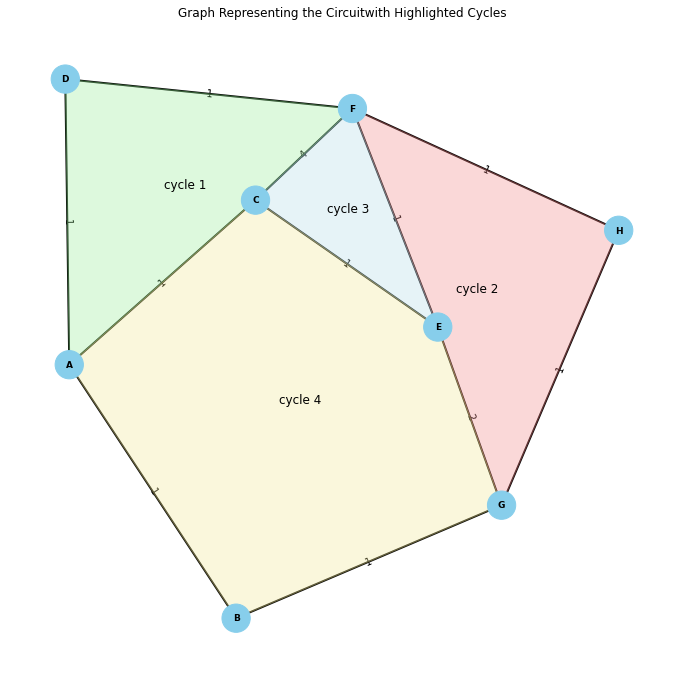

Minimum base cycles: [['D', 'F', 'C', 'A'], ['G', 'H', 'F', 'E'], ['E', 'F', 'C'], ['B', 'G', 'E', 'C', 'A']]


In [424]:
# Create a simple graph

G = nx.Graph()


G.add_node('A', label='A') 
G.add_node('B', label='B')  
G.add_node('C', label='C') 
G.add_node('D', label='D')  
G.add_node('E', label='E')  
G.add_node('F', label='F') 
G.add_node('G', label='G')  
G.add_node('H', label='H')

edges = [
    ('A', 'B', 1),  
    ('A', 'C', 1), 
    ('A', 'D', 1),  
    ('C', 'E', 1),
    ('C', 'F', 4), 
    ('F', 'E', 1),  
    ('F', 'D', 1),  
    ('E', 'G', 2),  
    ('G', 'B', 1), 
    ('G', 'H', 1),  
    ('H', 'F', 1)
]


G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)

# Obtaining the minimum cycle basis
all_cycles = nx.minimum_cycle_basis(G)


# Draw the graph with the cycles
draw_graph_with_cycles(G, pos, all_cycles)

print("Minimum base cycles:", all_cycles)




In the previous graph, suppose we want to find the minimum cut with the restriction that the cut must necessarily pass through the edge connecting nodes D and F, and we also want it to pass through the edge between G and H. To achieve this, we identify that there are four minimum cycles, and I can jump from one cycle to another by crossing an edge. For example, from cycle 1, I can move to cycle 3 by cutting an edge with weight 4, or I can go to cycle 4 by cutting an edge with weight 1. In the flow graph, we will have a node for each cycle, and each cycle is connected to its neighbor by an edge with weight equivalent to the cost of moving from one cycle to the other. For example cycle 1 is connected to cycle 3 by an edge with weight 4, and to cycle 4 by an edge with weight 1.

Since the cut must also pass through the edge between G and H, this means that at some point, we must jump to cycle 2. So, in this new graph representing the flow, what remains is to find the minimum path using Dijkstra's algorithm between the nodes of cycle 1 and cycle 2, and then sum the weights of the edges from our restriction, the edges D-F and G-H. This will give us the minimum cut under this restriction.

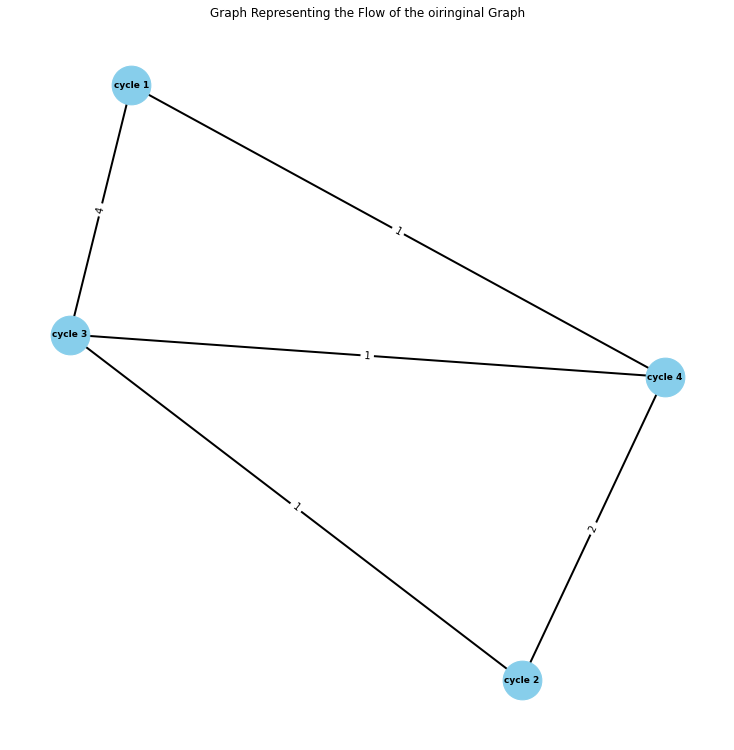

In [440]:
cycle_graph = convert_to_flowGraph(G)
pos = nx.spring_layout(cycle_graph)

# Draw the flow graph
plt.figure(figsize=(10, 10))
labels = nx.get_edge_attributes(cycle_graph, 'weight')
nx.draw(cycle_graph, pos, with_labels=True, node_color="skyblue", node_size=1500, font_size=9, font_weight="bold", width=2)
nx.draw_networkx_edge_labels(cycle_graph, pos, edge_labels=labels)
plt.title("Graph Representing the Flow of the oiringinal Graph")
plt.show()


In the flow graph, it is easy to identify that if we want to go from cycle 1 to cycle 2, the most optimal path is to first go from cycle 1 to cycle 4 and finally to cycle 2. This is exactly the minimum path that Dijkstra's algorithm would yield. Now, returning to the minimum cut problem, once we know the cost of cutting the cycles to traverse the original graph, the only thing left is to sum the weights of the initial and final edges, the edges D-F and G-H, which is exactly 5 if you review the original graph.

In [443]:
min_path, path_weight_sum = min_path_fluxGraph(cycle_graph, 'cycle 1', 'cycle 2')


print("The shortest path between cycle 1 and cycle 2 is:", min_path)
print("The sum of the edge weights on the path is:", path_weight_sum)
print("So the minimal cut in the original graph cutting the edgs D-F and G-H has a weight of: ", path_weight_sum + G['D']['F']['weight'] + G['G']['H']['weight'])

The shortest path between cycle 1 and cycle 2 is: ['cycle 1', 'cycle 4', 'cycle 2']
The sum of the edge weights on the path is: 3
So the minimal cut in the original graph cutting the edgs D-F and G-H has a weight of:  5


<h2 style="color: #FF6347;"> Finding the minimal cut in a quantum circuit represented by a graph</h2>

In [29]:
def min_cut(G, pos, cut):
    """
    This function calculates the minimum cut in a graph by identifying the cycles
    and calculating the path between the cycles that contain specific qubits and the 'S' node.
    It also positions the 'S' node at the center of the graph horizontally with a fixed vertical position.
    """

    u, v = cut
    G = G.copy()
    n_qubits = sum([1 for node in G.nodes() if node.startswith('q_top')])

    # Connect the qubits in the top row
    for i in range(n_qubits - 1):
        G.add_edge(f'q_top_{i}', f'q_top_{i+1}', weight=0)
            
    # Add edges between the qubits below
    for i in range(n_qubits - 1):
        G.add_edge(f'q_bottom_{i}', f'q_bottom_{i+1}', weight=0)
    
    # Add a node below the row of qubits that connects to the initial and final qubits
    G.add_node('exit', label='exit', node_color='yellow')
    G.add_edge('exit', f'q_bottom_0', weight=1)
    G.add_edge('exit', f'q_bottom_{n_qubits-1}', weight=1)
    
    # Calculate the center position in the X-axis for placing 'exit' at the middle of the graph
    x_position = sum([pos[node][0] for node in G.nodes() if node.startswith('q_top')]) / n_qubits
    pos['exit'] = (x_position, -3)

    # Identify the cycle of q_top_u and q_top_v, and the cycle of exit
    basis_cycles, cycle_edges = find_basic_cycles_with_edges(G)
    
    cycle_origin = ''
    for c in basis_cycles:
        if f'q_top_{u}' in c and f'q_top_{v}' in c:
            cycle_origin = f"cycle {basis_cycles.index(c) + 1}"
            break

    cycle_final = ''
    for c in basis_cycles:
        if 'exit' in c:
            cycle_final = f"cycle {basis_cycles.index(c) + 1}"
            break

    cycle_graph = convert_to_flowGraph(G)
    
    # Uncomment if you want to see the graph of minimal cut flow graphs
    
    draw_graph_with_cycles(G, pos, basis_cycles)

    pos1 = nx.spring_layout(cycle_graph)
    plt.figure(figsize=(10, 10))
    labels = nx.get_edge_attributes(cycle_graph, 'weight')
    nx.draw(cycle_graph, pos1, with_labels=True, node_color="skyblue", node_size=1500, font_size=9, font_weight="bold", width=2)
    nx.draw_networkx_edge_labels(cycle_graph, pos1, edge_labels=labels)
    plt.title("Graph Representing the Flow of the oiringinal Graph")
    plt.show()
    
    min_path, path_weight_sum = min_path_fluxGraph(cycle_graph, f'{cycle_origin}', f'{cycle_final}')

    
    return min_path, path_weight_sum

<h2 style="color: #1E90FF;"> Example of use for a simple circuit </h1>

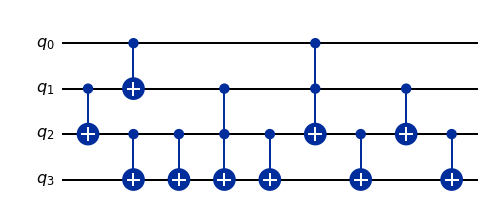

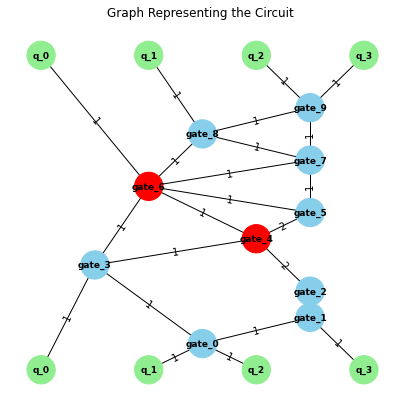

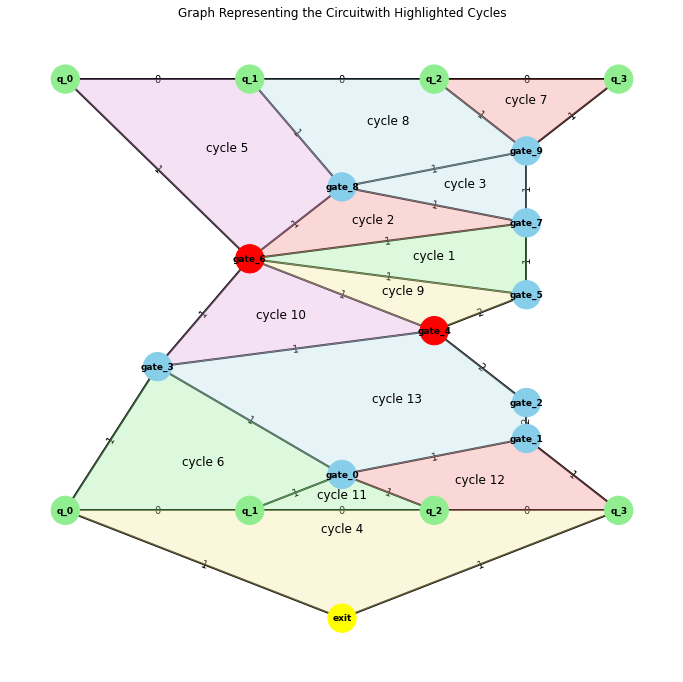

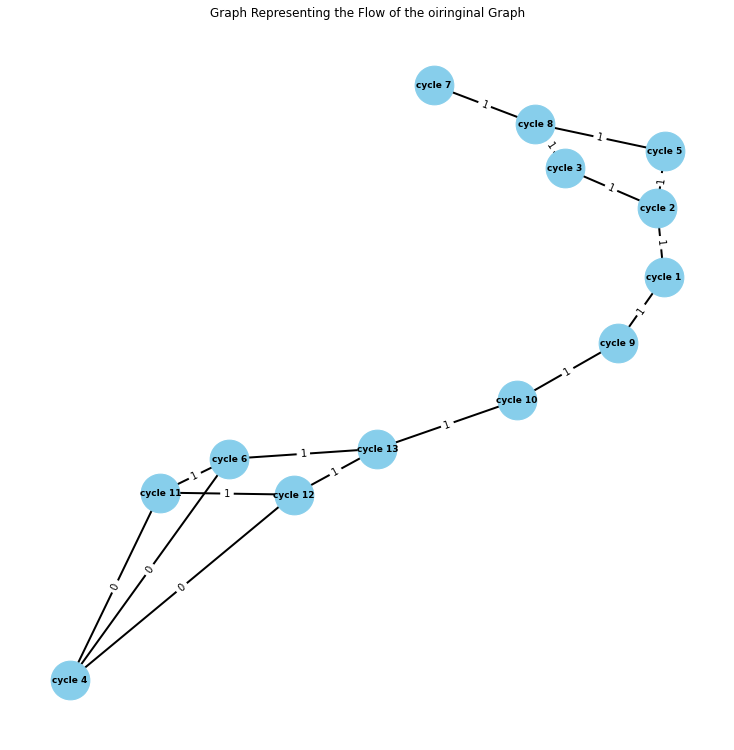

The minimum cut is: 7
The minimum path is: ['cycle 8', 'cycle 3', 'cycle 2', 'cycle 1', 'cycle 9', 'cycle 10', 'cycle 13', 'cycle 6', 'cycle 4']


In [34]:
n_qubits = 4
gates = 10
doped = 0.2 # Doping percentage (3-Qubit gates)
cut = [1, 2]

# Create the graph and the circuit

G, pos, gates = random_circuit_to_graph(n_qubits, gates, doped)
qc = gates_to_circuit(n_qubits, gates)


# Draw the circuit and graph

display(qc.draw(output='mpl'))
draw_circuit_graph(G, pos)


# Convert the graph to a flow graph
cycle_graph = convert_to_flowGraph(G)
pos1 = nx.spring_layout(cycle_graph)


# Calculate the minimum cut in the circuit

min_path, min_cut_value = min_cut(G, pos, cut)
print("The minimum cut is:", min_cut_value)
print("The minimum path is:", min_path)

<h2 style="color: #FF6347;"> This is a simple test of the algorithm for studying circuits with 3 qubits </h2>

In a circuit with 3 qubis, we have only two possible paths to follow, and every gate on the road forces us to change paths. Therefore we obtain a well-known distribution; The probability density of the cut in this case is given by binomial distribution.

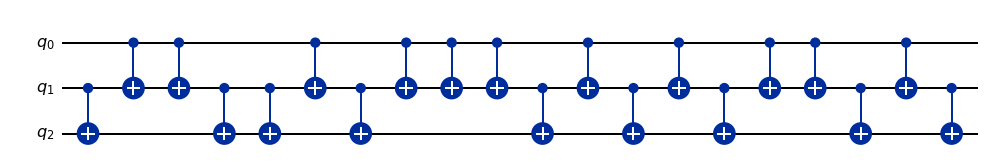

The minimum cut is: 14


In [499]:
depth = 20
n_qubits = 3
cut = [0, 1]

G, pos, gates = random_circuit_to_graph(n_qubits, depth)
qc = gates_to_circuit(n_qubits, gates)

display(qc.draw(output='mpl'))
min_path, min_cut_value = min_cut(G, pos, cut)
print("The minimum cut is:", min_cut_value)

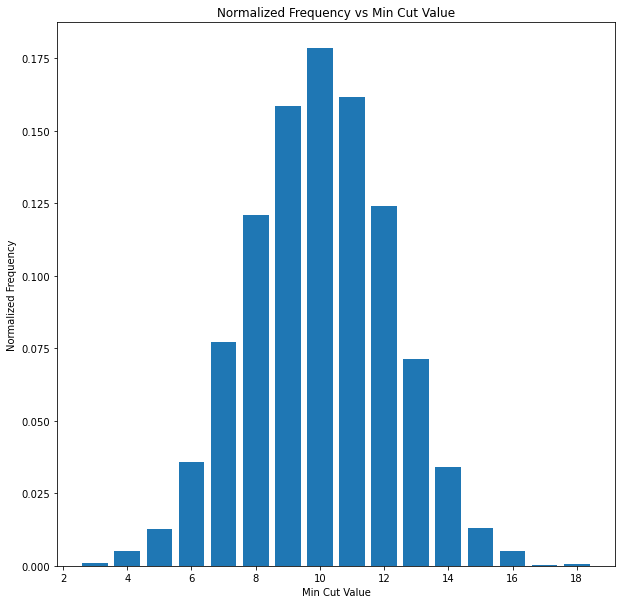

In [502]:
iteration = 5000
depth = 20
n_qubits = 3
cut = [0, 1]

cut_values = []
for _ in range(iteration):
    G, pos, gates = random_circuit_to_graph(n_qubits, depth)
    path_cut, min_cut_value  = min_cut(G, pos, cut)
    cut_values.append(min_cut_value)
    
from collections import Counter
cut_count = Counter(cut_values)

total_iterations = len(cut_values)
normalized_freq = {k: v / total_iterations for k, v in cut_count.items()}

sorted_cut_values = sorted(normalized_freq.keys())
sorted_frequencies = [normalized_freq[val] for val in sorted_cut_values]

plt.figure(figsize=(10, 10))
plt.bar(sorted_cut_values, sorted_frequencies)
plt.xlabel('Min Cut Value')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Frequency vs Min Cut Value')
plt.show()

The most probable cut is given by 1/2 # gates. So the slope of cut value against depth is 1/2


Slope of the line: 0.4982761104441779


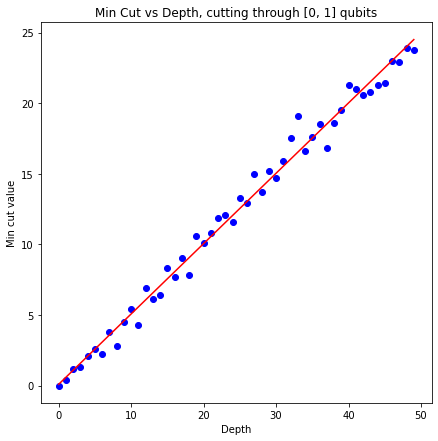

In [5]:
iteration = 10
n_qubits = 3
depth = 50
cut = [0, 1]

# Calculate the min cut average value for multiple iterations and multiple number of gates
data = []
for gate in range(depth):
    cut_values = []
    for _ in range(iteration):
        G, pos, gates = random_circuit_to_graph(n_qubits, gate)
        min_path, min_cut_value = min_cut(G, pos, cut)
        cut_values.append(min_cut_value)
    data.append((gate, np.mean(cut_values)))
    

#calculate the slope of the line
data = np.array(data)
m, c = np.polyfit(data[:, 0], data[:, 1], 1)

plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], color='blue')
plt.title(f'Min Cut vs Depth, cutting through {cut} qubits')
plt.xlabel('Depth')
plt.ylabel('Min cut value')

plt.plot(data[:, 0], m * data[:, 0] + c, color='red')

print("Slope of the line:", m) 